# Salt Body Interpretation on Seismic Using Sagemaker and MXNET

This notebook contains a tutorial on how to build a deep learning (semantic segmentation) model for automatic salt interpretation. 
* The fully convolutional architecture known as UNet for semantic segmentation
* How to train UNet in Amazon SageMaker, and deploy to an inference endpoint

Import the following modules:

In [11]:
import mxnet as mx
import segmentation_methods as sgm
from mxnet import ndarray as F
import numpy as np
import urllib
from PIL import Image
np.random.seed(1984)
import glob
import os
import urllib
import zipfile
from scipy.misc import imresize
from sklearn.cross_validation import train_test_split
import scipy.io as sio
from skimage import measure
import time
import matplotlib.pyplot as plt
%matplotlib inline

# Data ingestion

The dataset use din this study is provided by TGS. Here is a link to data: https://www.kaggle.com/c/tgs-salt-identification-challenge
We load the names of the files containing the labels. For each image that has a label, we load that name.

In [14]:
image_dir = 'data/train/images/'
image_files = sgm.get_file_path_list(image_dir)
label_dir = 'data/train/masks/'
label_files = sgm.get_file_path_list(label_dir)

Here we load the masks, and convert them into a binary format"
* If the images are not the same resolution, so they are resized to a constant 820x550. Any interpolated label values greater than zero are set to one.
* MXNet requires the input to have dimension <tt>(batch, channel, height, width)</tt>, so these alterations are made.

In [16]:
image1 = np.array(Image.open(image_files[100]).resize((550,820)))
mask1 = np.array(Image.open(label_files[100]).resize((550,820)))

Text(0.5,1,'Salt Mask')

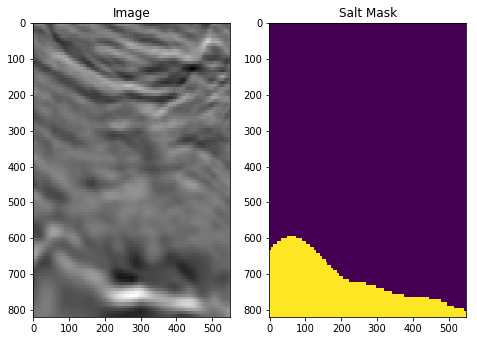

In [17]:
plt.figure(figsize=(12,12))
plt.subplot(131)
plt.title('Image')
plt.imshow(image1)

plt.subplot(132)
plt.imshow(mask1)
plt.title('Salt Mask')

## Stack images

In [18]:
X = []
Y = []
for i in range(len(image_files)):
    mask = (Image.open(label_files[i]))
    mask = (imresize(mask, (820, 550)) > 0).astype(np.uint8) # interpolate to 820 x 550
    image = np.array(Image.open(image_files[i]).resize((550,820)))
    X.append(image)
    Y.append(mask)
X = np.transpose(np.stack(X), axes=(0, 3, 1, 2))
Y = np.expand_dims(np.stack(Y), 1)

/home/ec2-user/anaconda3/envs/mxnet_p27/lib/python2.7/site-packages/ipykernel/__main__.py:5: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


We have 4000 observations.

In [19]:
X.shape

(4000, 3, 820, 550)

# Data splitting and augmentation (random cropping)

We're going to generate a new data-set through random cropping of our existing images. Before we do that, we need to split the data into training and validation data (if we did crops first, and then split, we run the risk of data leakage).

In [20]:
train_X, validation_X, train_Y, validation_Y = train_test_split(X, Y, test_size=0.2, random_state=1984)

In [23]:
train_X_boxes, train_Y_boxes = sgm.extract_boxes(train_X, train_Y)
validation_X_boxes, validation_Y_boxes = sgm.extract_boxes(validation_X, validation_Y)

Next, we generate the random crops.

In [26]:
train_X_crops, train_Y_crops = sgm.generate_random_crops(train_X_boxes, train_Y_boxes, num_patches=3)
validation_X_crops, validation_Y_crops = sgm.generate_random_crops(validation_X_boxes, validation_Y_boxes, num_patches=3)

In [27]:
train_X_crops.shape

(6327, 3, 256, 256)

Next, we'll save the generated data locally so we can avoid generating again.

In [29]:
if not os.path.exists('/dev/shm/salt/segmentation_data'): 
    os.mkdir('/dev/shm/salt/segmentation_data')
np.save('/dev/shm/salt/segmentation_data/train_X_crops.npy', train_X_crops)
np.save('/dev/shm/salt/segmentation_data/train_Y_crops.npy', train_Y_crops)
np.save('/dev/shm/salt/segmentation_data/validation_X_crops.npy', validation_X_crops)
np.save('/dev/shm/salt/segmentation_data/validation_Y_crops.npy', validation_Y_crops)

In [30]:
train_X_crops = np.load('/dev/shm/salt/segmentation_data/train_X_crops.npy')
train_Y_crops = np.load('/dev/shm/salt/segmentation_data/train_Y_crops.npy')
validation_X_crops = np.load('/dev/shm/salt/segmentation_data/validation_X_crops.npy')
validation_Y_crops = np.load('/dev/shm/salt/segmentation_data/validation_Y_crops.npy')

# SageMaker

We're going to proceed by defining the UNet Network for binary segmentation using Sagemaker.

Now we are ready to define a training job in SageMaker to do training at scale.

In [31]:
import boto3
import sagemaker
from sagemaker.mxnet import MXNet
from sagemaker import get_execution_role

In [32]:
role = get_execution_role()
sagemaker_session = sagemaker.Session()

We need to upload the data to S3 so the instances launched for the training job can pull the data down.

In [33]:
inputs = sagemaker_session.upload_data(path='/dev/shm/salt/segmentation_data', key_prefix='sagemaker_data')

INFO:sagemaker:Created S3 bucket: sagemaker-us-east-1-597844091762


Finally, we create the MXNet SageMaker model estimator using the **Bring your own script** paradigm. We've defined a script, <tt>segmentation.py</tt>, that runs the training loop for UNet in MXNet Symbolic. To do this, we follow the conventions defined for the SageMaker Python SDK [here](https://github.com/aws/sagemaker-python-sdk).

## Train

In [56]:
#SAGEMAKER NOTEBOOK CODE
sagemaker_net = MXNet("segmentation.py", 
                  role=role, 
                  train_instance_count=5, 
                  train_instance_type="ml.p3.16xlarge",
                  sagemaker_session=sagemaker_session,
                  hyperparameters={
                                 'data_shape': (3, 256, 256),
                                 'batch_size': 64, 
                                 'epochs': 100, 
                                 'learning_rate': 1E-3, 
                                 'num_gpus': 1,
                                  })

sagemaker_net.fit(inputs)

INFO:sagemaker:Creating training-job with name: sagemaker-mxnet-2018-11-26-21-30-05-962


2018-11-26 21:30:06 Starting - Starting the training job...
2018-11-26 21:30:10 Starting - Launching requested ML instances.........
2018-11-26 21:31:49 Starting - Preparing the instances for training......
2018-11-26 21:32:57 Downloading - Downloading input data...
2018-11-26 21:33:34 Training - Downloading the training image..
2018-11-26 21:33:44,287 INFO - root - running container entrypoint
2018-11-26 21:33:44,287 INFO - root - starting train task
2018-11-26 21:33:44,412 INFO - container_support.training - Training starting
2018-11-26 21:33:46,436 WARNING - mxnet_container.train - #033This required structure for training scripts will be deprecated with the next major release of MXNet images. The train() function will no longer be required; instead the training script must be able to be run as a standalone script. For more information, see https://github.com/aws/sagemaker-python-sdk/tree/master/src/sagemaker/mxnet#updating-your-mxnet-training-script.#033
2018-11-26 21:33:46,509 INFO


2018-11-26 21:46:14 Uploading - Uploading generated training modelBest model at Epoch 10
Epoch 10: Moving Training Loss -0.53428, Validation Loss -0.53301
2018-11-26 21:46:03,030 INFO - root - Saved checkpoint to "best_net-0000.params"
/usr/local/lib/python2.7/dist-packages/mxnet/module/base_module.py:54: UserWarning: #033You created Module with Module(..., label_names=['softmax_label']) but input with name 'softmax_label' is not found in symbol.list_arguments(). Did you mean one of:
#011data#033
  warnings.warn(msg)
/usr/local/lib/python2.7/dist-packages/mxnet/module/base_module.py:66: UserWarning: Data provided by label_shapes don't match names specified by label_names ([] vs. ['softmax_label'])
  warnings.warn(msg)
Epoch 10: Moving Training Loss -0.52459, Validation Loss -0.50957
/usr/local/lib/python2.7/dist-packages/mxnet/module/base_module.py:54: UserWarning: #033You created Module with Module(..., label_names=['softmax_label']) but input with name 'softmax_label' is not found i

Once the training is complete, we can launch an endpoint server that serves inference with our trained model.

In [43]:
sagemaker_predictor = sagemaker_net.deploy(initial_instance_count=1, instance_type='ml.p2.xlarge')

INFO:sagemaker:Creating model with name: sagemaker-mxnet-2018-10-29-03-49-07-684
INFO:sagemaker:Creating endpoint with name sagemaker-mxnet-2018-10-29-03-49-07-684


---------------------------------------------------------------------------------------!

## Test

In [44]:
test_iter = mx.io.NDArrayIter(data = validation_X_crops, label=validation_Y_crops, batch_size=1, shuffle=False)

We can send test data to the inference endpoint:

In [51]:
batch = next(test_iter)
data = batch.data[0]
label = batch.label[0]
response = sagemaker_predictor.predict(data.asnumpy().tolist())
output = np.array(response[0])

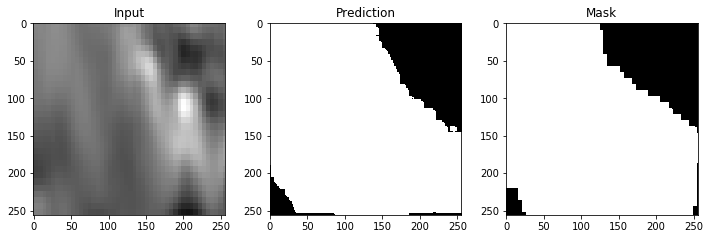

In [52]:
width = 12
height = 12
plt.figure(figsize=(width, height))
plt.subplot(331)
plt.title('Input')
plt.imshow(np.transpose(data.asnumpy()[0], (1,2,0)).astype(np.uint8))
plt.subplot(332)
plt.title('Prediction')
plt.imshow(post_process_mask(output[0]), cmap=plt.cm.gray)
plt.subplot(333)
plt.title('Mask')
plt.imshow(label[0][0].asnumpy(), cmap=plt.cm.gray)

Don't forget to delete your endpoint when you're done with it.

In [ ]:
sagemaker_net.delete_endpoint()